In [8]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("carrie1/ecommerce-data")

print("Path to dataset files:", path)
# List all files in the dataset directory

import os
file_names = os.listdir(path)
print("Files in dataset directory:", file_names)

Path to dataset files: C:\Users\uniat\.cache\kagglehub\datasets\carrie1\ecommerce-data\versions\1
Files in dataset directory: ['data.csv']


In [9]:
df = pd.read_csv(path+'//data.csv', encoding='ISO-8859-1')

In [10]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]  # Remove returns
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()
daily_sales.columns = ['ds', 'y']


In [11]:

# Data validation
if len(daily_sales) < 14:  # Need at least 2 weeks for weekly decomposition
    print(f"Error: Only {len(daily_sales)} days of data. Need at least 14 days.")
    exit()
print(f"Dataset size: {len(daily_sales)} days")


Dataset size: 305 days


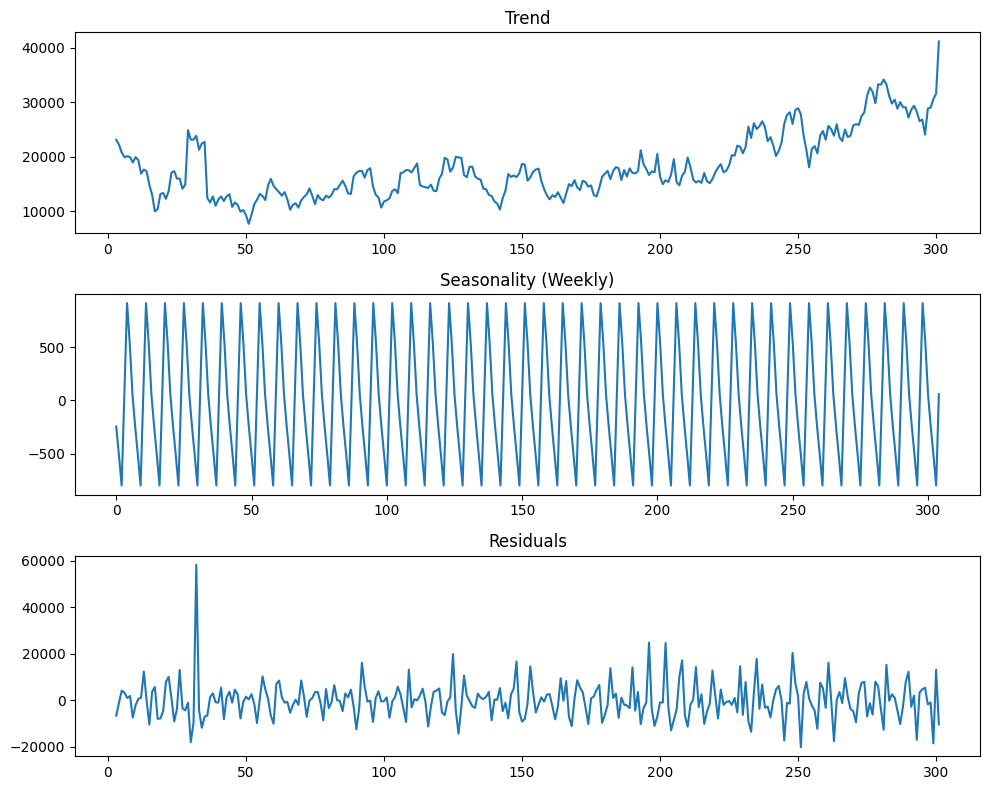

In [12]:

# Feature engineering
daily_sales['day_of_week'] = daily_sales['ds'].apply(lambda x: x.weekday())
daily_sales['month'] = daily_sales['ds'].apply(lambda x: x.month)

# Decompose time series (weekly cycle: period=7)
decomp = seasonal_decompose(daily_sales['y'], model='additive', period=7)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomp.trend.plot(ax=ax1, title='Trend')
decomp.seasonal.plot(ax=ax2, title='Seasonality (Weekly)')
decomp.resid.plot(ax=ax3, title='Residuals')
plt.tight_layout()
plt.show()


In [13]:

# Split data for training/testing
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# ML: Train Prophet model with regressors
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.add_regressor('day_of_week')
model.add_regressor('month')
model.fit(train)


00:28:51 - cmdstanpy - INFO - Chain [1] start processing
00:28:51 - cmdstanpy - INFO - Chain [1] done processing


In [14]:

# Predict and evaluate
future = model.make_future_dataframe(periods=len(test))
future['day_of_week'] = future['ds'].apply(lambda x: x.weekday())
future['month'] = future['ds'].apply(lambda x: x.month)
forecast = model.predict(future)
mae = mean_absolute_error(test['y'], forecast['yhat'][-len(test):])
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 12473.89


In [15]:

# Visualization: Interactive plot with confidence intervals
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], name='Train', mode='lines'))
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], name='Test', mode='lines'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast', mode='lines'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', 
                         mode='none', name='Upper CI', opacity=0.2))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', 
                         mode='none', name='Lower CI', opacity=0.2))
fig.update_layout(title='E-Commerce Sales Forecast (Weekly Analysis)',
                  xaxis_title='Date', yaxis_title='Sales Quantity')
fig.show()

In [19]:
import plotly.graph_objs as go
from plotly.offline import iplot

world_map = df[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)


layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)
